In [177]:
import numpy as np
import matplotlib.pyplot as plt
import cma

# Defining Model Curves

### Pruning vs Accuracy

In [178]:
def get_accuracy(p):
    b0 = 93.09
    b1 = -42.86
    b2 = 378.6
    b3 = -1230
    b4 = 900.9
    b5 = 487.6
    b6 = -589.0

    acc = b0 + b1 * p + b2 * p**2 + b3 * p**3 + b4 * p**4 + b5 * p**5 + b6 * p**6

    return max(acc, 0)

### Pruning vs Model Size

In [179]:
def get_size(p):
    b1 = -427.4
    b0 = 480.4
    
    return b0 + b1 * p

### Pruning vs Inference Time

In [180]:
def get_time(p):
    b0 = 1.020
    b1 = -1.417
    b2 = 3.677
    b3 = -3.275
    
    return b0 + b1 * p + b2 * p**2 + b3 * p**3

# Defining Rewards

### Accuracy Reward

In [181]:
def get_accuracy_reward(curr_accuracy, min_accuracy, sigma_right=4, sigma_left=2):
    diff = curr_accuracy - min_accuracy
    if 0<=diff<=1e-2:
        return np.exp(- (diff**1.6) / (10 * sigma_left**2)) * 100
    else:
        return np.exp(- (abs(diff)**1.5) / (2 * sigma_right**2)) * 100

In [182]:
# min_accuracy = float(input("Enter the minimum acceptable accuracy: ") or 80.0)
acc_rewards = []
accuracies = []
pruning_amounts = np.arange(0.0, 1.001, 0.001)
for p in pruning_amounts:
    accuracy = get_accuracy(p)
    reward = get_accuracy_reward(accuracy, min_accuracy=80)
    accuracies.append(accuracy)
    acc_rewards.append(reward)

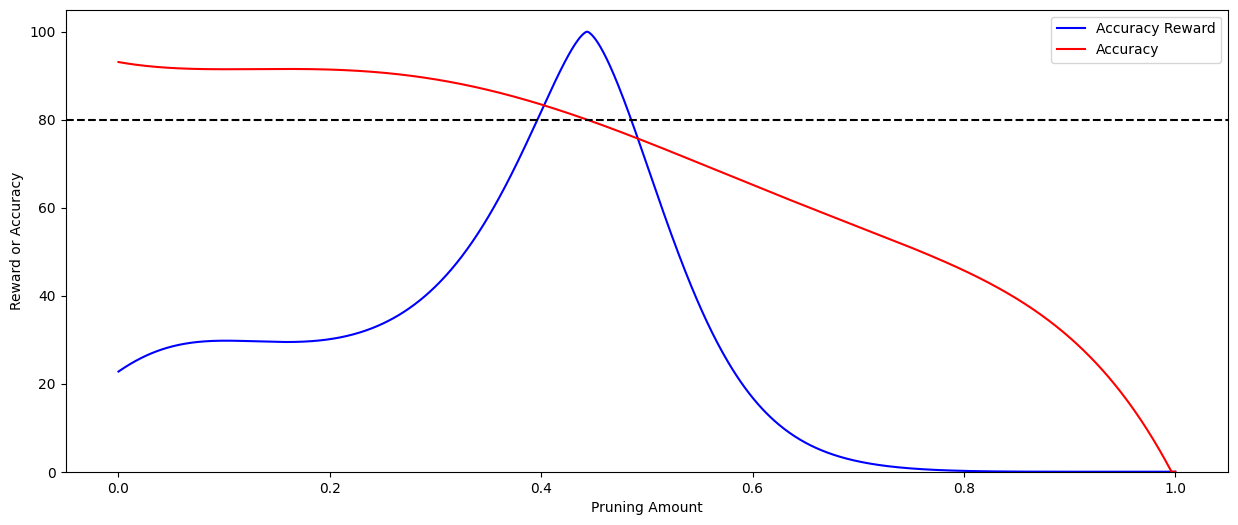

In [183]:
plt.style.use('default')
plt.figure(figsize=(15, 6), dpi=100)
plt.plot(pruning_amounts, acc_rewards, label='Accuracy Reward', color='blue')
plt.plot(pruning_amounts, accuracies, label='Accuracy', color='red')
plt.ylim(0)
plt.axhline(y=80, color='black', linestyle='--')
plt.xlabel('Pruning Amount')
plt.ylabel('Reward or Accuracy')
plt.legend()

### Inference Time Reward

In [184]:
def get_comp_time_reward(current_comp_time, sigma=0.8):
    return np.exp(- (current_comp_time**2) / (2 * sigma**2))*100

In [185]:
time_rewards = []
comp_times = []
for p in pruning_amounts:
    time = get_time(p)
    reward = get_comp_time_reward(time)
    comp_times.append(time)
    time_rewards.append(reward)

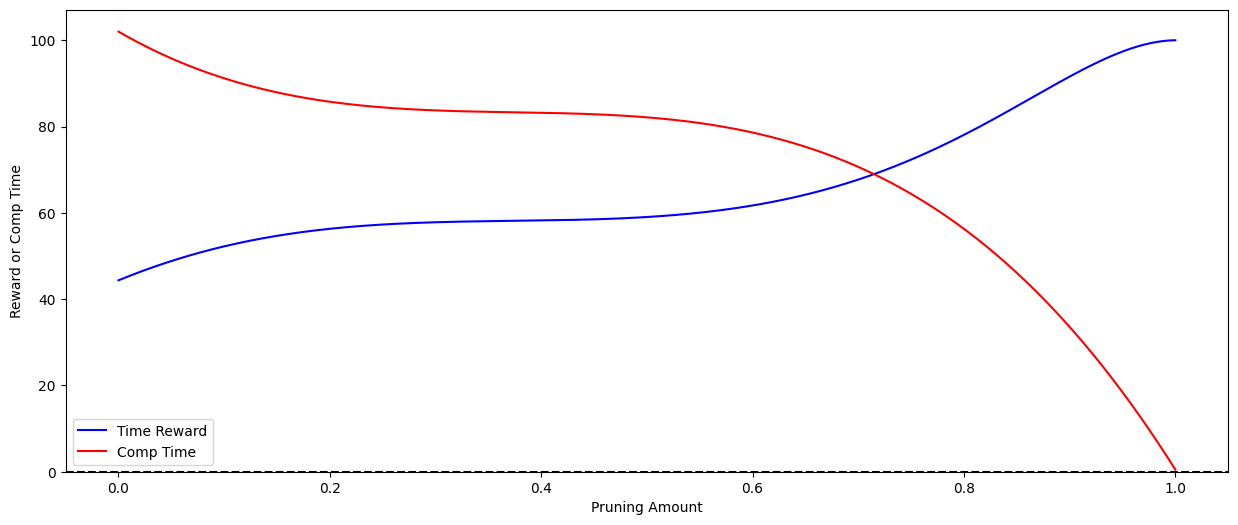

In [186]:
plt.style.use('default')
plt.figure(figsize=(15, 6), dpi=100)
plt.plot(pruning_amounts, time_rewards, label='Time Reward', color='blue')
plt.plot(pruning_amounts, [x * 100 for x in comp_times], label='Comp Time', color='red')
plt.ylim(0)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Pruning Amount')
plt.ylabel('Reward or Comp Time')
plt.legend()

### Model Size Reward

In [187]:
def get_model_size_reward(current_model_size, max_model_size, sigma_left=2):
    diff = current_model_size - max_model_size
    if current_model_size > max_model_size:
        return np.exp(- (abs(diff)**2) / (10 * sigma_left**2)) * 100
    if current_model_size == max_model_size:
        return 100
    else:
        return 100+(max_model_size/current_model_size)
    

In [188]:
size_rewards = []
sizes = []
# max_model_size = float(input("Enter the maximum acceptable model size: ") or 300.0)
for p in pruning_amounts:
    size = get_size(p)
    reward = get_model_size_reward(size, max_model_size=300)
    sizes.append(size)
    size_rewards.append(reward)

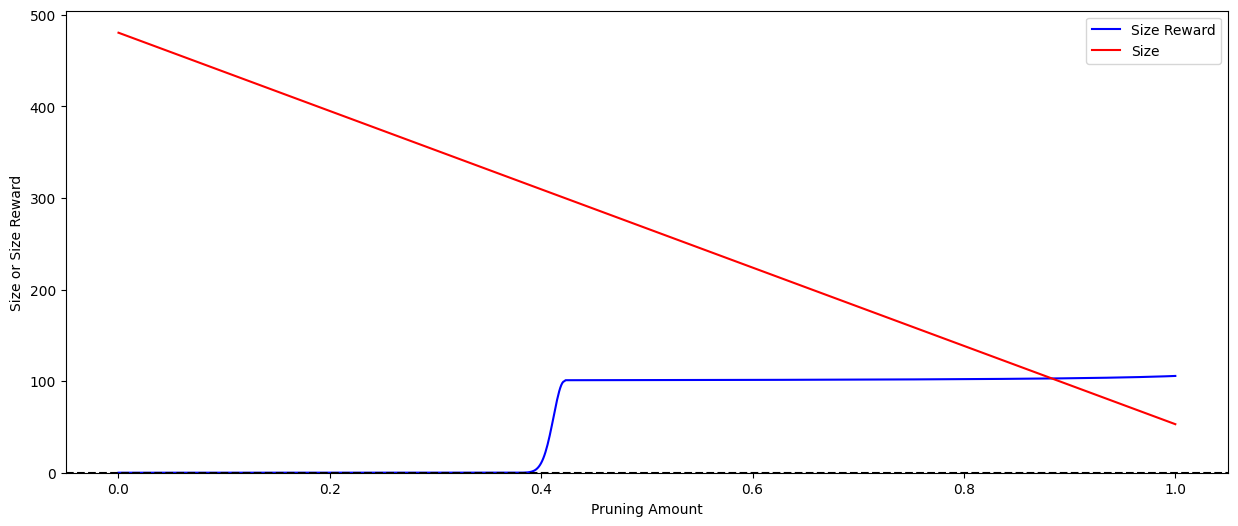

In [189]:
plt.style.use('default')
plt.figure(figsize=(15, 6), dpi=100)
plt.plot(pruning_amounts, size_rewards, label='Size Reward', color='blue')
plt.plot(pruning_amounts, sizes, label='Size', color='red')
plt.ylim(0)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Pruning Amount')
plt.ylabel('Size or Size Reward')
plt.legend()

### Reward for better pruning

In [190]:
def more_acc_less_size(accuracy, min_accuracy, size, max_model_size):
    if accuracy >= min_accuracy and size <= max_model_size:
        return ((accuracy-min_accuracy)*2) + (max_model_size-size)/2
    return 0

In [191]:
counts_of_calulating_rewards = 0

### Final Reward Calculation

In [192]:
def get_reward(p, min_accuracy=80.0, max_model_size=300.0) -> float:
    accuracy = get_accuracy(p)
    time = get_time(p)
    size = get_size(p)
    
    acc_reward = np.array(get_accuracy_reward(accuracy, min_accuracy))
    time_reward = np.array(get_comp_time_reward(time))
    size_reward = np.array(get_model_size_reward(size, max_model_size))
    better_reward = more_acc_less_size(accuracy, min_accuracy, size, max_model_size)
    global counts_of_calulating_rewards
    counts_of_calulating_rewards += 1 # type: ignore
    
    return (acc_reward + time_reward + size_reward + better_reward + p*10).item()

In [193]:
def get_details(p):
    return {
        'Pruning Amount': p,
        "Accuracy": get_accuracy(p),
        "Time": get_time(p),
        "Size": get_size(p),
        "Accuracy Reward": get_accuracy_reward(get_accuracy(p), min_accuracy),
        "Time Reward": get_comp_time_reward(get_time(p)),
        "Size Reward": get_model_size_reward(get_size(p), max_model_size),
        "More Acc Less Size Reward": more_acc_less_size(get_accuracy(p), min_accuracy, get_size(p), max_model_size),
        "Pruning Reward": p * 100,
        "Total Reward": get_reward(p),
    }

# Global Optimization with CMA-ES
Here we apply the CMA-ES evolutionary strategy for robust, gradient-free maximization of the total reward over the pruning amount.

In [194]:
def get_best_pruning_amount(min_accuracy=80.0, max_model_size=300.0, normalized_importance=None):
    def objective(x):
        p = x[0]
        return -1 * get_reward(p, min_accuracy=min_accuracy, max_model_size=max_model_size)

    x0 = [0.5, 0.0]
    sigma = 0.4
    bounds = [[0.0, -float('inf')], [1.0, float('inf')]]

    es = cma.CMAEvolutionStrategy(x0, sigma, {
        'bounds': bounds,
        'popsize': 20,
        'CMA_diagonal': 0
    })

    for _ in range(100):
        candidates = es.ask()
        fitnesses = [objective(c) for c in candidates]
        es.tell(candidates, fitnesses)

    opt_p = es.result.xbest[0]
    # print(f"CMA-ES found optimal pruning amount: {opt_p:.4f}")
    # print(f"Maximum reward: {-es.result.fbest:.4f}")
    # print(f"Number of reward calculations: {counts_of_calulating_rewards}") # type: ignore
    return opt_p.item()

In [195]:
rewards = [get_reward(p) for p in pruning_amounts]
max_index = np.argmax(rewards)
max_reward = rewards[max_index]

In [196]:
min_accuracy = float(input("Enter the minimum acceptable accuracy: ") or 80.0)
max_model_size = float(input("Enter the maximum acceptable model size: ") or 300.0)

In [197]:
opt_p = get_best_pruning_amount(min_accuracy=min_accuracy, max_model_size=max_model_size)

(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 2 (seed=971461, Wed Jun 25 22:25:21 2025)
NOTE (module=cma, iteration=23):  
condition in coordinate system exceeded 1.5e+08, rescaled to 1.0e+00, 
condition changed from 6.4e+07 to 1.0e+00


/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.13/site-packages/cma/evolution_strategy.py:1244: UserWarning: Sampling standard deviation i=0 at iteration 0 change by 0.8333333333333333 to stds[0]=0.3333333333333333
  warnings.warn("Sampling standard deviation i={0} at iteration {1}"


In [198]:
print(opt_p)

1.0


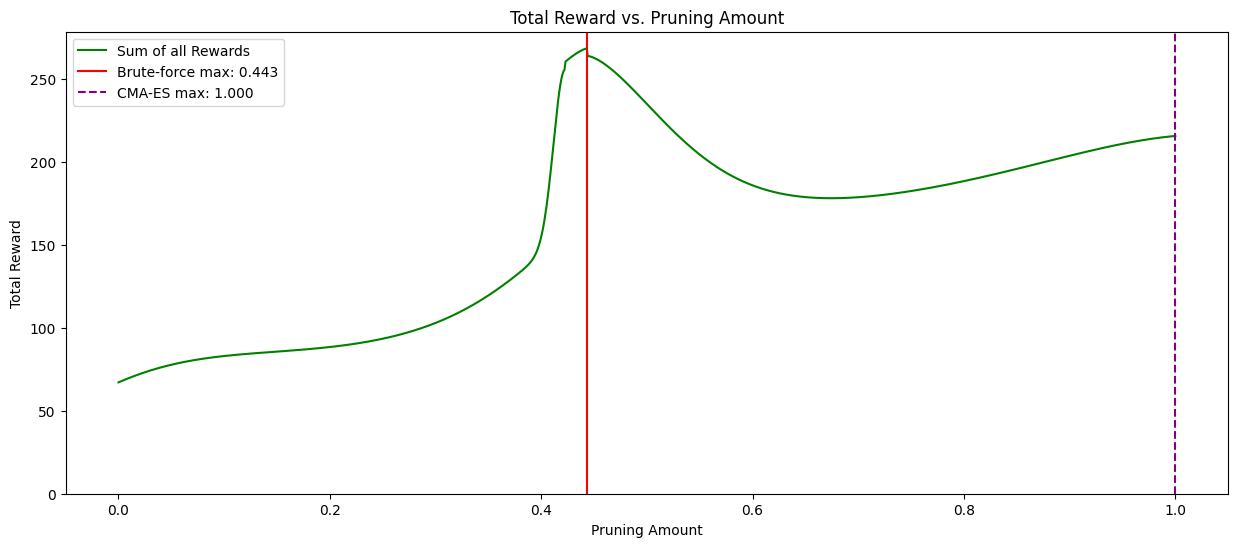

Brute-force search optimal pruning amount: 0.4430
CMA-ES found optimal pruning amount: 1.0000
Reward at brute-force optimum: 268.42
Reward at CMA-ES optimum: 215.66


In [199]:
# Plotting the results to compare brute-force and CMA-ES
plt.style.use('default')
plt.figure(figsize=(15, 6), dpi=100)
plt.plot(pruning_amounts, rewards, label='Sum of all Rewards', color='green')

# Brute-force result
brute_force_p = pruning_amounts[max_index]
plt.axvline(x=brute_force_p, color='red', linestyle='-', label=f'Brute-force max: {brute_force_p:.3f}')

# CMA-ES result
plt.axvline(x=opt_p, color='purple', linestyle='--', label=f'CMA-ES max: {opt_p:.3f}')

plt.ylim(0)
plt.xlabel('Pruning Amount')
plt.ylabel('Total Reward')
plt.title('Total Reward vs. Pruning Amount')
plt.legend()
plt.show()

print(f"Brute-force search optimal pruning amount: {brute_force_p:.4f}")
print(f"CMA-ES found optimal pruning amount: {opt_p:.4f}")

# Also print the rewards at these points
reward_brute_force = get_reward(brute_force_p)
reward_cma_es = get_reward(opt_p)

print(f"Reward at brute-force optimum: {reward_brute_force:.2f}")
print(f"Reward at CMA-ES optimum: {reward_cma_es:.2f}")

In [200]:
get_details(brute_force_p)

{'Pruning Amount': np.float64(0.443),
 'Accuracy': np.float64(80.03313313412143),
 'Time': np.float64(0.829153617575),
 'Size': np.float64(291.06179999999995),
 'Accuracy Reward': np.float64(70.26725812400349),
 'Time Reward': np.float64(58.443714953347126),
 'Size Reward': np.float64(9.290180493750804e-89),
 'More Acc Less Size Reward': 0,
 'Pruning Reward': np.float64(44.3),
 'Total Reward': 268.4209448716784}

# Importance of Each View

In [201]:
ranking = {
    0: 1.0,
    10: 0.7142857142857143,
    6: 0.4166666666666667,
    7: 0.35714285714285715,
    1: 0.2631578947368421,
    3: 0.2631578947368421,
    9: 0.23809523809523808,
    5: 0.2173913043478261,
    8: 0.2,
    2: 0.18518518518518517,
    4: 0.16666666666666666,
    11: 0.15151515151515152
    }

In [202]:
total = sum(ranking.values())
ranking = {k: v / total for k, v in ranking.items()}
ranking

{0: 0.23962056141346544,
 10: 0.17115754386676105,
 6: 0.09984190058894395,
 7: 0.08557877193338052,
 1: 0.06305804247722775,
 3: 0.06305804247722775,
 9: 0.05705251462225368,
 5: 0.05209142639423162,
 8: 0.047924112282693096,
 2: 0.044374178039530636,
 4: 0.03993676023557757,
 11: 0.036306145668706886}

In [203]:
ranking_unsorted = {
    view: drop
    for view, drop in sorted(
        ranking.items(),
        key=lambda item: item[0],
        reverse=False
    )
}

In [204]:
ranking_unsorted

{0: 0.23962056141346544,
 1: 0.06305804247722775,
 2: 0.044374178039530636,
 3: 0.06305804247722775,
 4: 0.03993676023557757,
 5: 0.05209142639423162,
 6: 0.09984190058894395,
 7: 0.08557877193338052,
 8: 0.047924112282693096,
 9: 0.05705251462225368,
 10: 0.17115754386676105,
 11: 0.036306145668706886}

In [205]:
max_imp = max(ranking.values())
min_imp = min(ranking.values())

In [206]:
normalized_importance = {
    v: (ranking[v] - min_imp) / (max_imp - min_imp) for v in ranking
}

In [207]:
normalized_importance

{0: 1.0,
 10: 0.663265306122449,
 6: 0.3125,
 7: 0.24234693877551025,
 1: 0.13157894736842107,
 3: 0.13157894736842107,
 9: 0.10204081632653061,
 5: 0.07763975155279505,
 8: 0.057142857142857176,
 2: 0.039682539682539666,
 4: 0.017857142857142846,
 11: 0.0}

# Importance-Inverse Pruning Strategy

This implementation ensures a strict inverse relationship between view importance and pruning amount:
- Higher importance views → Lower pruning (preserve important views)
- Lower importance views → Higher pruning (aggressively prune less important views)

The approach directly incorporates this relationship into the CMA-ES objective function.

In [208]:
def get_importance_inverse_pruning(normalized_importance, global_accuracy=85.0, max_model_size=300.0):
    """
    Calculate pruning amounts that are strictly inversely proportional to view importance.
    HIGHER IMPORTANCE = LESS PRUNING
    LOWER IMPORTANCE = MORE PRUNING
    """
    import numpy as np
    
    # Define a function to compute the weighted average accuracy
    def compute_weighted_accuracy(pruning_amounts):
        per_view_acc = {v: get_accuracy(pruning_amounts[v]) for v in normalized_importance}
        # Normalize weights for proper weighted average
        weight_sum = sum(normalized_importance.values())
        normalized_weights = {k: v/weight_sum for k, v in normalized_importance.items()}
        weighted_acc = sum(normalized_weights[v] * per_view_acc[v] for v in normalized_importance)
        return weighted_acc
    
    # Sort views by importance (descending)
    sorted_views = sorted(normalized_importance.keys(), 
                         key=lambda v: normalized_importance[v], 
                         reverse=True)
    
    # Get the min and max importance values
    # min_imp = min(normalized_importance.values())
    # max_imp = max(normalized_importance.values())
    
    # DIRECTLY ESTABLISH INVERSE RELATIONSHIP:
    # High importance (1.0) → Low pruning (0.0)
    # Low importance (0.0) → High pruning (0.9)
    # Using a simple linear inverse mapping
    pruning_per_view = {}
    for view in normalized_importance:
        # Calculate pruning as inverse of normalized importance
        # Map importance [0,1] to pruning [0.9,0.0]
        importance = normalized_importance[view]
        pruning = 0.9 * (1 - importance)
        pruning_per_view[view] = pruning
    
    # Check weighted accuracy with this pruning strategy
    weighted_acc = compute_weighted_accuracy(pruning_per_view)
    
    # If we miss the target accuracy, adjust pruning while maintaining the inverse relationship
    if weighted_acc < global_accuracy:
        print(f"Initial weighted accuracy {weighted_acc:.2f}% is below target {global_accuracy:.2f}%.")
        print("Adjusting pruning while preserving inverse importance relationship...")
        
        # Binary search to find the right scaling factor
        # that preserves the inverse relationship
        def find_scaling_factor():
            # Scale range: lower values = less pruning = higher accuracy
            min_scale = 0.0  # No pruning (highest accuracy)
            max_scale = 1.0  # Original pruning
            best_scale = max_scale
            
            for _ in range(20):  # Binary search iterations
                mid_scale = (min_scale + max_scale) / 2
                
                # Apply scaling while preserving inverse relationship
                scaled_pruning = {
                    v: pruning_per_view[v] * mid_scale 
                    for v in pruning_per_view
                }
                
                current_acc = compute_weighted_accuracy(scaled_pruning)
                
                if current_acc >= global_accuracy:
                    # This scale works, try to increase it (more pruning)
                    min_scale = mid_scale
                    best_scale = mid_scale  # Save this working scale
                else:
                    # This scale doesn't work, decrease it (less pruning)
                    max_scale = mid_scale
            
            return best_scale
        
        # Find the optimal scaling factor
        scale_factor = find_scaling_factor()
        
        # Apply scaling to all views
        pruning_per_view = {
            v: pruning_per_view[v] * scale_factor 
            for v in pruning_per_view
        }
        
        # Check if we still miss the target with maximum scaling
        weighted_acc = compute_weighted_accuracy(pruning_per_view)
        
        if weighted_acc < global_accuracy:
            print("Scaling approach insufficient. Applying selective pruning reduction...")
            
            # Reduce pruning progressively for most important views first
            for view in sorted_views:
                current_pruning = pruning_per_view[view]
                # Try reducing pruning for this view
                pruning_per_view[view] = current_pruning * 0.5
                
                # Check if we've reached target accuracy
                current_acc = compute_weighted_accuracy(pruning_per_view)
                
                if current_acc >= global_accuracy:
                    break
                    
                # If still not enough, try zero pruning for this view
                if current_acc < global_accuracy:
                    pruning_per_view[view] = 0.0
                    
                    # Check if we've reached target accuracy
                    if compute_weighted_accuracy(pruning_per_view) >= global_accuracy:
                        break
    
    # Calculate final weighted accuracy
    final_weighted_acc = compute_weighted_accuracy(pruning_per_view)
    
    # Check correlation to verify inverse relationship
    imp_values = np.array(list(normalized_importance.values()))
    prune_values = np.array([pruning_per_view[v] for v in normalized_importance])
    correlation = np.corrcoef(imp_values, prune_values)[0, 1]
    
    # Report results
    print(f"Target accuracy: {global_accuracy:.2f}%")
    print(f"Achieved weighted accuracy: {final_weighted_acc:.2f}%")
    print(f"Correlation between importance and pruning: {correlation:.4f}")
    if correlation < 0:
        print("Negative correlation confirms inverse relationship between importance and pruning")
    else:
        print("WARNING: Inverse relationship not maintained")
    
    return pruning_per_view

In [209]:
result = get_importance_inverse_pruning(normalized_importance, global_accuracy=min_accuracy, max_model_size=max_model_size)

Target accuracy: 75.00%
Achieved weighted accuracy: 75.87%
Correlation between importance and pruning: -1.0000
Negative correlation confirms inverse relationship between importance and pruning


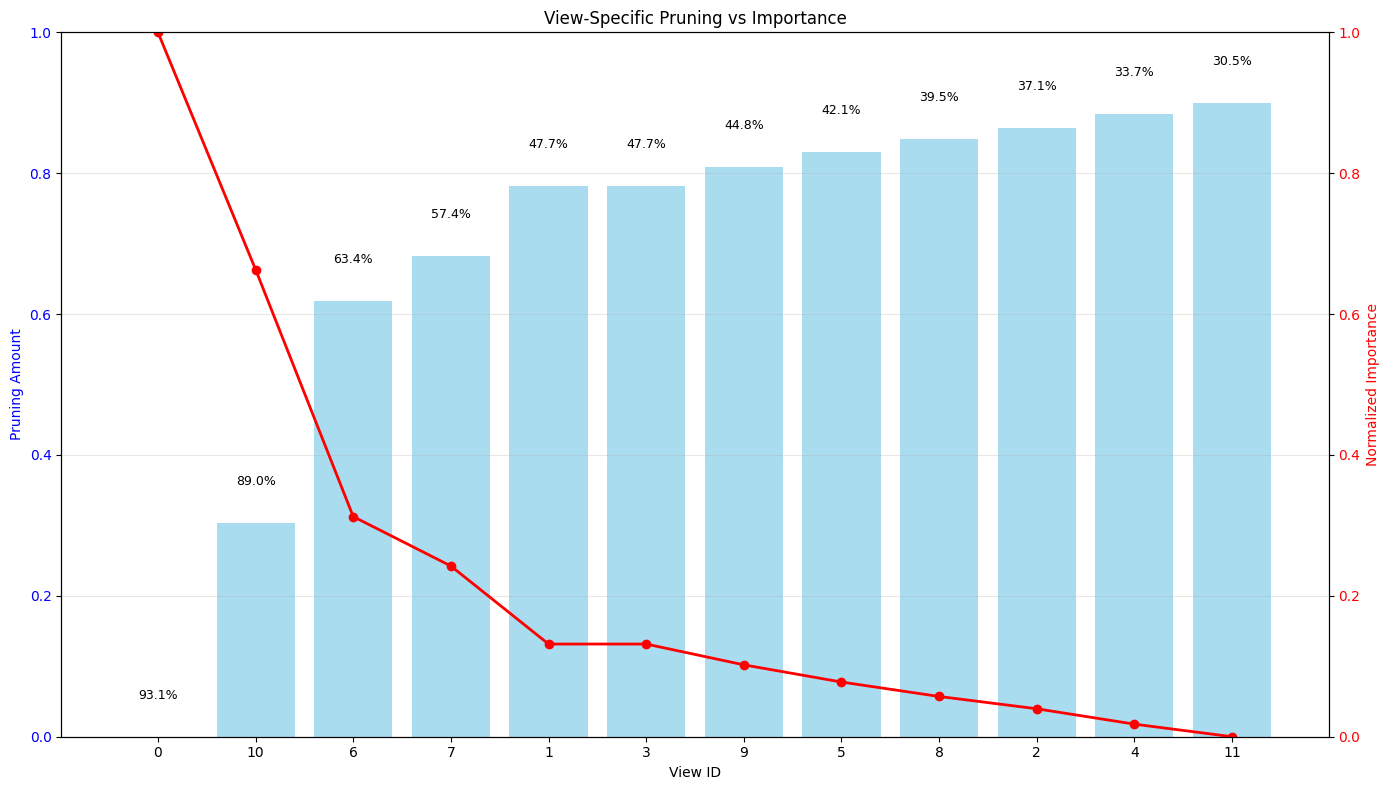

In [210]:
# Visualize the pruning results
import matplotlib.pyplot as plt
import pandas as pd

def plot_pruning_results(pruning_per_view, normalized_importance):
    # Create a DataFrame for easy plotting
    df = pd.DataFrame({
        'View': list(pruning_per_view.keys()),
        'Pruning': list(pruning_per_view.values()),
        'Importance': [normalized_importance[v] for v in pruning_per_view.keys()]
    })
    
    # Sort by importance
    df = df.sort_values('Importance', ascending=False)
    
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Plot bars for pruning amounts
    bars = ax1.bar(df['View'].astype(str), df['Pruning'], color='skyblue', alpha=0.7)
    ax1.set_xlabel('View ID')
    ax1.set_ylabel('Pruning Amount', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_ylim(0, 1.0)
    
    # Plot line for importance
    ax2 = ax1.twinx()
    ax2.plot(range(len(df)), df['Importance'], 'ro-', linewidth=2)
    ax2.set_ylabel('Normalized Importance', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_ylim(0, 1.0)
    
    # Calculate per-view accuracies after pruning
    accuracies = [get_accuracy(p) for p in df['Pruning']]
    
    # Add text labels for accuracies
    for i, (p, acc) in enumerate(zip(df['Pruning'], accuracies)):
        ax1.text(i, p + 0.05, f"{acc:.1f}%", 
                 ha='center', va='bottom', rotation=0, fontsize=9)
    
    plt.title('View-Specific Pruning vs Importance')
    plt.tight_layout()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

# After calculating the result
plot_pruning_results(result, normalized_importance)

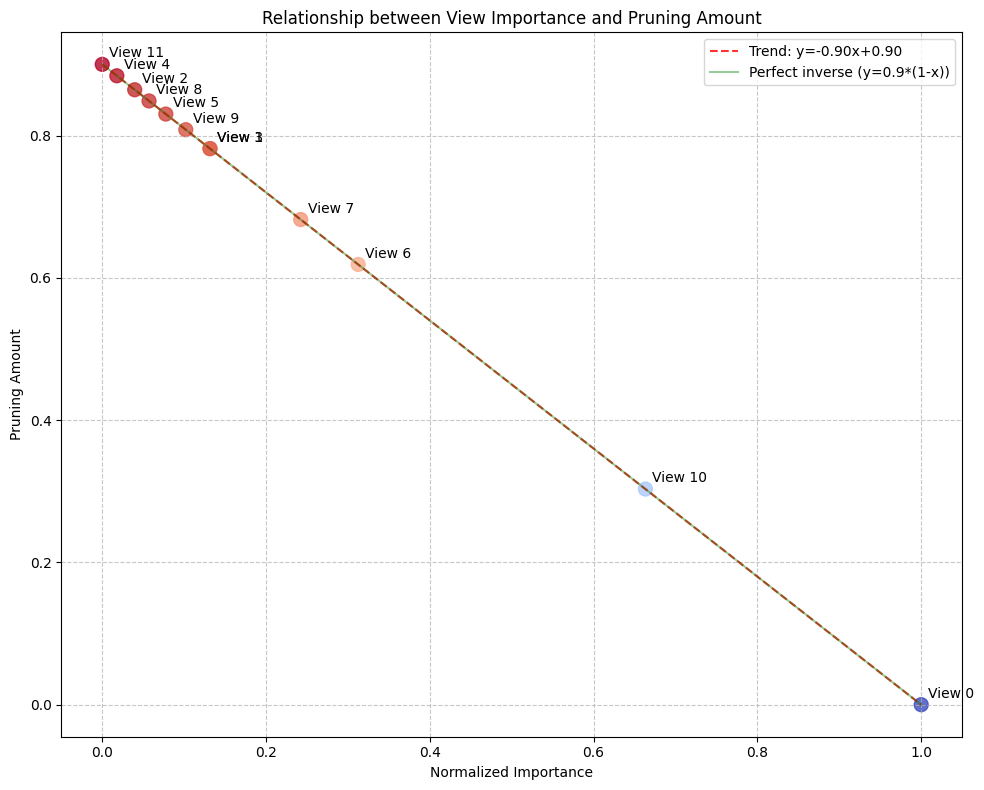

Correlation coefficient: -1.0000
Negative correlation indicates inverse relationship
R²: 1.0000


In [211]:
# Visualize Importance vs. Pruning relationship
def visualize_importance_pruning_relationship(pruning_per_view, normalized_importance):
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Extract values for scatter plot
    importance_values = []
    pruning_values = []
    view_ids = []
    
    for view, importance in normalized_importance.items():
        importance_values.append(importance)
        pruning_values.append(pruning_per_view[view])
        view_ids.append(view)
    
    # Create the scatter plot
    plt.figure(figsize=(10, 8))
    
    # Main scatter plot
    plt.scatter(importance_values, pruning_values, s=100, c=pruning_values, 
                cmap='coolwarm', alpha=0.8)
    
    # Add view ID labels
    for i, view_id in enumerate(view_ids):
        plt.annotate(f"View {view_id}", 
                    (importance_values[i], pruning_values[i]),
                    xytext=(5, 5), textcoords='offset points')
    
    # Add trend line
    z = np.polyfit(importance_values, pruning_values, 1)
    p = np.poly1d(z)
    plt.plot(sorted(importance_values), p(sorted(importance_values)), 
             "r--", alpha=0.8, label=f"Trend: y={z[0]:.2f}x+{z[1]:.2f}")
    
    # Add labels and title
    plt.xlabel('Normalized Importance')
    plt.ylabel('Pruning Amount')
    plt.title('Relationship between View Importance and Pruning Amount')
    
    # Add horizontal and vertical grid lines
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add perfect inverse relationship reference line
    x_ref = np.linspace(0, 1, 100)
    y_ref = 0.9 * (1 - x_ref)  # The ideal inverse relationship
    plt.plot(x_ref, y_ref, 'g-', alpha=0.4, label="Perfect inverse (y=0.9*(1-x))")
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Calculate and print correlation
    correlation = np.corrcoef(importance_values, pruning_values)[0, 1]
    print(f"Correlation coefficient: {correlation:.4f}")
    print("Negative correlation indicates inverse relationship")
    print(f"R²: {correlation**2:.4f}")

# Visualize the importance-pruning relationship
visualize_importance_pruning_relationship(result, normalized_importance)

In [212]:
!jupyter nbconvert "mvcnn-results-reg-fit.ipynb" --to pdf --output "mvcnn-results-reg-fit.pdf" --no-prompt > /dev/null 2>&1